In [ ]:
import numpy as np
import pandas as pd
import pypsa
import os
from pathlib import Path
import seaborn as sns

In [ ]:
n = pypsa.Network(Path.cwd().parent.parent.parent / "cluster_data" / "chp_data" / "elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2050_1300_elec_flex.nc")

In [ ]:
buses = n.loads.loc[n.loads.carrier == "electricity"].index

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
mode = "chp"

print(os.listdir(Path.cwd().parent.parent.parent / "cluster_data" / "chp_data"))
n = pypsa.Network(Path.cwd().parent.parent.parent / "cluster_data" / "chp_data" / f"elec_s_72_lv1.0__Co2L0-3H-T-H-B-I-solar+p3-dist1_2050_1500_{mode}_flex.nc")

In [ ]:
renewables = ["solar", "onwind", "offwind-dc", "offwind-ac"]
data = pd.DataFrame(index=buses, columns=renewables)

for carrier in renewables:
    
    # print(n.generators.loc[n.generators.carrier == carrier].index)
    gens = n.generators.loc[n.generators.carrier == carrier].bus

    caps = n.generators_t.p_max_pu[gens.index].mean()

    data.loc[gens.tolist(), carrier] = caps.values
    # break

data.fillna(0, inplace=True)
data

In [ ]:
n.loads.carrier.unique()

In [ ]:
n.loads.carrier.unique()

In [ ]:
generation_targets = {
    "dh": ["geothermal heat dh"],
    "chp": ["geothermal heat chp district heat", "geothermal heat chp elec"],
    # "elec": ["electricity"],
    "elec": ["geothermal heat elec"],
}
load_targets = {
    "dh": ["urban central heat"],
    "chp": ["urban central heat", "electricity", "AC"],
    # "elec": ["electricity"],
    "elec": ["AC"],
}

geothermal_buses = n.links.loc[n.links.carrier.isin(generation_targets[mode])].bus1.unique()

gen_gens = n.generators.loc[n.generators.bus.isin(geothermal_buses)]

def get_total_generation(name):
    try:
        return n.generators_t.p[name].sum()
    except KeyError:
        return 0.

gen_gens.loc[:, "total_gen"] = pd.Series(gen_gens.index, gen_gens.index).apply(lambda name: get_total_generation(name))

gen_links = (gen_links := n.links.loc[n.links.bus1.isin(geothermal_buses)]).loc[gen_links.carrier != "DC"]

gen_links.loc[:, "total_gen"] = pd.Series(gen_links.index, gen_links.index).apply(lambda name: n.links_t.p1[name].sum() * (-1.))
gen_links["bus"] = gen_links.bus1

all_gens = pd.concat((
    gen_links[["bus", "total_gen", "carrier"]],
    gen_gens[["bus", "total_gen", "carrier"]]
))

In [ ]:
geothermal_mask = all_gens.carrier.isin(generation_targets[mode])

geothermal_gen = (ag := all_gens.loc[geothermal_mask]).groupby(ag.bus.str[:5]).sum()["total_gen"]
total_gen = all_gens.groupby(all_gens.bus.str[:5]).sum()["total_gen"]

data["geothermal generation share"] = geothermal_gen / total_gen

In [ ]:
def get_geothermal_capacity(n, mode):

    gt = pd.concat((
        (
            (gg := n.links.loc[n.links.carrier.isin(generation_targets[mode])])["p_nom_opt"] * gg["efficiency"]
            ).rename('p_nom_opt')
        ,
        gg["location"],
        gg["carrier"]
    ), axis=1)

    gt.index = gt.location

    gt = pd.concat((
        gt.loc[gt.carrier == carrier, "p_nom_opt"].rename(carrier) for carrier in gt.carrier.unique()
    ), axis=1)
    
    return gt


capacity = get_geothermal_capacity(n, "chp")
# print(capacity)

print(get_geothermal_capacity(n, "chp"))
data[generation_targets[mode]] = get_geothermal_capacity(n, mode)


In [ ]:
data

In [ ]:
def get_dac_capacity(n):

    dac = n.links.loc[n.links.carrier == "DAC"]
    dac = dac.loc[dac.bus3.str.contains("urban central heat")]
    dac.index = dac.bus2

    return dac["p_nom_opt"]

data['dac'] = get_dac_capacity(n)

data

In [ ]:
def get_district_heating_share(n):
    
    heating_carriers = [
        "urban central heat",
        "residential urban decentral heat",
        "services urban decentral heat",
    ]

    uch = n.loads.loc[n.loads.carrier == "urban central heat"].index

    uch = n.loads_t.p_set[uch.intersection(n.loads_t.p_set.columns)].sum().reindex(uch, fill_value=0.)
    uch.index = uch.index.str[:5]

    other_heat = n.loads_t.p_set[n.loads.loc[n.loads.carrier.isin(heating_carriers).index.intersection(n.loads_t.p_set.columns)].index].sum()
    other_heat = other_heat.reindex(n.loads.loc[n.loads.carrier.isin(heating_carriers)].index, fill_value=0.)
    other_heat = other_heat.groupby(other_heat.index.str[:5]).sum()

    share = uch.div(other_heat)

    fig, ax = plt.subplots(1, 1, figsize=(17, 5))
    share.plot.bar(ax=ax)
    plt.show()

    return share

    
# district_heating_share = get_district_heating_share(n)
data["district heating share"] = get_district_heating_share(n)

In [ ]:
data

In [ ]:
import seaborn as sns
from itertools import product

for col1, col2, in product(data.columns, data.columns):

    if col1 == col2:
        continue

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    sns.scatterplot(x=col1, y=col2, data=data, ax=ax)
    ax.grid(True)
    plt.show()

print(data.cor)
sns.pairplot(data)



In [ ]:
geothermal = (gt := all_gens.loc[all_gens.carrier.str.contains("geothermal")]).groupby(gt.bus.str[:5]).sum()["total_gen"]

print(geothermal.head())
print(geothermal.shape)
print("==========================")

totals = all_gens.groupby(all_gens.bus.str[:5]).sum()["total_gen"]
print(totals.head())
print(totals.shape)
print("==========================")

share = geothermal / totals

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
share.sort_values().plot.bar(ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

all_gens.groupby("carrier").sum()["total_gen"].plot(kind="bar", ax=ax)

ax.set_yscale("log")
plt.show()
all_gens.groupby("carrier").sum()["total_gen"]

In [ ]:
idx = n.loads_t.p_set.columns

idx[idx.str.contains("urban central heat")].shape
print(loads_idx.shape)
print(n.loads.loc['IT3 0 urban central heat'])

In [ ]:
n.loads_t.p_set[loads_idx.intersection(n.loads_t.p_set.columns)].sum().sum()

In [ ]:
n.links.loc[n.links.bus0.str.contains("urban central heat")]

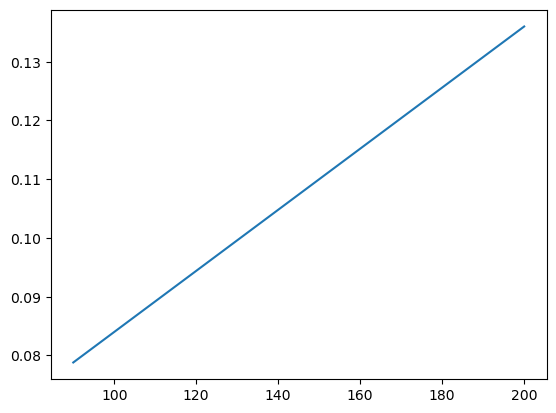

In [2]:
import numpy as np
import matplotlib.pyplot as plt

f = lambda T: 0.00052 * T + 0.032

plt.plot((x:=np.linspace(90, 200, 100)), f(x))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

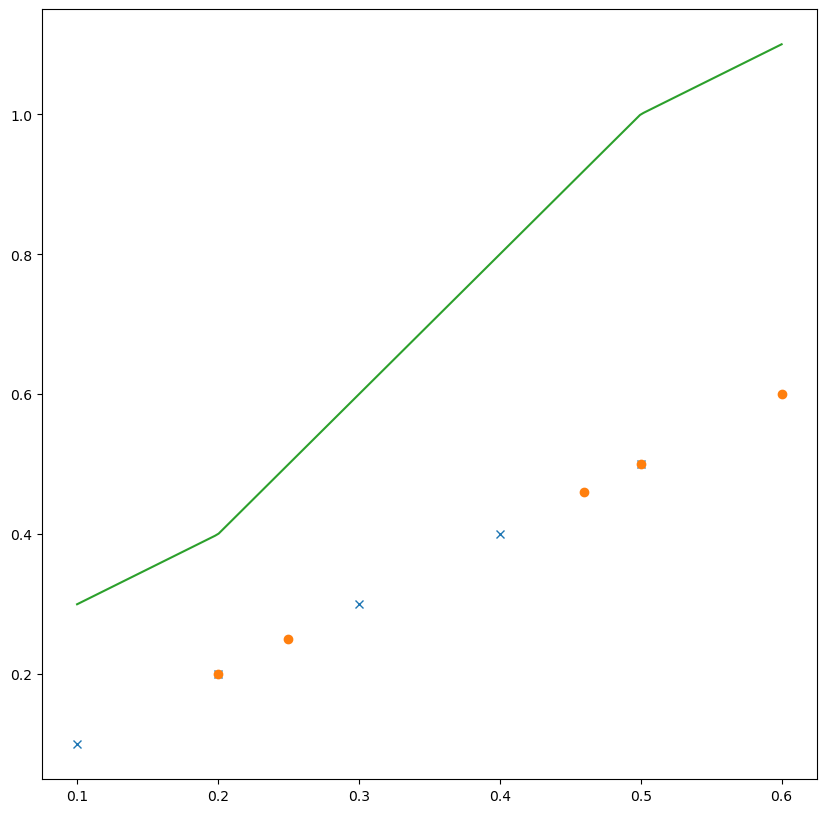

In [3]:
x1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
x2 = np.array([0.2, 0.25, 0.46, 0.5, 0.6])

y1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
y2 = np.array([0.2, 0.25, 0.46, 0.5, 0.6])

joint_x = np.linspace((c := np.concatenate((x1, x2))).min(), c.max(), 200)

harmonized_y1 = np.interp(joint_x, x1, y1)
harmonized_y2 = np.interp(joint_x, x2, y2)

joint_y = harmonized_y1 + harmonized_y2


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(x1, y1, 'x')
ax.plot(x2, y2, 'o')
ax.plot(joint_x, joint_y)

